In [ ]:
! pip install contractions

     |████████████████████████████████| 321 kB 4.7 MB/s 
     |████████████████████████████████| 284 kB 48.4 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85442 sha256=7b0331a7952ea0d96590ea9498e0dab494f4ce52c223c9941e4c53f6ec03700e
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
! pip install transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 35.8 MB/s 
     |████████████████████████████████| 596 kB 45.4 MB/s 
     |████████████████████████████████| 895 kB 38.9 MB/s 
     |████████████████████████████████| 59 kB 6.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Imports

In [ ]:
import pandas as pd
import numpy as np
# import contractions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm


# bert imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm.notebook import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nltk
import gc
import os
# from BertForHumorDetection import BertForHumorDetection
import sklearn
import time
import csv
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score
from datetime import datetime

import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#GPU Info

In [ ]:
print('========================== GPU INFO ==========================')
os.system('nvcc --version')
print('--------------------------------------------------------------')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print('Is CUDA available: ', torch.cuda.is_available())
print('N_GPU: ', n_gpu)
print('GPU: ', torch.cuda.get_device_name(0))
print('--------------------------------------------------------------')
print('Monitor GPU by running following command in new terminal: watch -n 0.5 nvidia-smi')
print('Monitor system resources by running commands like free, top and htop in new terminal.')
print('--------------------------------------------------------------')

========================== GPU INFO ==========================
--------------------------------------------------------------
Is CUDA available:  True
N_GPU:  1
GPU:  Tesla K80
--------------------------------------------------------------
Monitor GPU by running following command in new terminal: watch -n 0.5 nvidia-smi
Monitor system resources by running commands like free, top and htop in new terminal.
--------------------------------------------------------------


# Setup

In [ ]:
# nltk.download('punkt') #required for tokenization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# nltk.download('averaged_perceptron_tagger') #required for lemmatization

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# nltk.download('wordnet') #required for lemmatization

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Constants

In [ ]:
MODEL_TYPE = 'bert-base-uncased'
LOGTIME = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
LR = 1e-5
MAX_SENTENCE_LEN = 20 #60 # twice longest sentence
MAX_NUM_SENTENCES = 5 #10 
MAX_SEQUENCE_LEN = 100 #120 # twice longest sequence
LOG_FIELDS = ['fold_id','fold_dur','epoch_id','fold_dur','batch_id','batch_dur','batch_size','loss','precision','recall','accuracy','f1','roc_auc']
LOG_PER_N_BATCH = 30
training_sample_count = 60000

# Directories

In [ ]:
DRIVE_DIR = os.path.join('/','content', 'drive', 'MyDrive')  # './' for storing CWD
# DRIVE_DIR = os.path.join('content', 'drive', 'MyDrive')
# PROJECT_REL_DIR = os.path.join('NLP project', 'humor-detection-2', 'humor-detection')
PROJECT_REL_DIR = os.path.join('NLP project', 'humor-detection')
PROJECT_DIR = os.path.join(DRIVE_DIR, PROJECT_REL_DIR)

# PROJECT_DIR = './' #uncomment to absolute paths

MODELS_REL_DIR = 'models'
MODELS_DIR = os.path.join(PROJECT_DIR, MODELS_REL_DIR)
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

LOGS_REL_DIR = 'logs'
LOGS_DIR = os.path.join(PROJECT_DIR, LOGS_REL_DIR)
if not os.path.exists(LOGS_DIR):
    os.makedirs(LOGS_DIR)

LOG_FILE = os.path.join(LOGS_DIR, 'bert-%s.log'%(LOGTIME))
LOG_FIELDS = ['fold_id','fold_dur','epoch_id','fold_dur','batch_id','batch_dur','batch_size','loss','precision','recall','accuracy','f1','roc_auc']

DATA_REL_DIR = 'data'
DATA_DIR = os.path.join(PROJECT_DIR, DATA_REL_DIR)
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)


with open(LOG_FILE, 'a') as csvfile:
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerow(LOG_FIELDS) 

# Load data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/NLP project/humor-detection/data/train.csv')
df_train

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
159995,Watch muhammad ali pull the greatest prank on ...,False
159996,Some days the problem is i care too much... to...,True
159997,If someone doesn't realize their blinker is st...,True
159998,I'm going out with a girl i met online who's a...,True


In [ ]:
# f = open(os.path.join(DATA_DIR,'train_contractions_lemmatization'),'rb')
# df_train = pickle.load(f)
# f.close()
# df_train

,text,humor
0,"Joe biden rule out 2020 bid : 'guys , I be not...",False
1,Watch : darvish give hitter whiplash with slow...,False
2,What do you call a turtle without it she will ...,True
3,5 reason the 2016 election feel so personal,False
4,Pasco police shot mexican migrant from behind ...,False
...,...,...
159995,Watch muhammad ali pull the great prank on uns...,False
159996,Some day the problem be i care too much ... to...,True
159997,If someone do not realize their blinker be sti...,True
159998,I be go out with a girl i met online who be a ...,True


In [ ]:
df_test = pd.read_csv(os.path.join(DATA_DIR,'dev.csv'))
df_test

,text,humor
0,What kind of cat should you take into the des...,True
1,Remember when people used to have to be in sha...,True
2,Pizza is always good. - everyone we'll see abo...,True
3,"What's 6 inches long hard, bent, and in my pan...",True
4,Black teen's response to violence in his commu...,False
...,...,...
39995,Conor maynard seamlessly fits old-school r&b h...,False
39996,How to you make holy water? you boil the hell ...,True
39997,How many optometrists does it take to screw in...,True
39998,Mcdonald's will officially kick off all-day br...,False


# Preprocess data

**1. Expand contractions**

In [ ]:
# df_train.text = df_train.text.apply(lambda sequence: contractions.fix(sequence))
# # contractions.fix("I hadn't done that")
# df_train

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, I am not ...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its she will...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
159995,Watch muhammad ali pull the greatest prank on ...,False
159996,Some days the problem is i care too much... to...,True
159997,If someone does not realize their blinker is s...,True
159998,I am going out with a girl i met online who is...,True


**#TODO**: Explore if contractions expansions is a good pre processing idea. 
For example, in below example 'shell' becomes 'she will' making no sense of humor.

In [ ]:
contractions.fix('What do you call a turtle without its shell? dead.')

'What do you call a turtle without its she will? dead.'

**2. Lemmatization with nltk**

In [ ]:
# tqdm.pandas() # https://stackoverflow.com/a/34365537/1317018 call tqdm.pandas() and call 'progress_xyz()' instead of any pandas methods `xyz()`  

# def get_wordnet_pos(word):
#     """Map POS tag to first character lemmatize() accepts"""
#     tag = nltk.pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ,
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}

#     return tag_dict.get(tag, wordnet.NOUN)

# lemmatizer = WordNetLemmatizer()

# df_train.text = df_train.text.progress_apply(lambda sequence: ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(sequence)]))

# # ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize('I dont think you get what I am saying')])

# df_train

  0%|          | 0/160000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

**#TODO** Analyze if lemmatization is good idea.
After analyzing different humors and their lemmatized versions, its seems so. 
But it was taking time to execute.

In [ ]:
pd.set_option('display.max_colwidth', None) # avoid pringing ... for long sequences
df_train.iloc[[30]].text

30    Ugh, i just spilled red wine all over the inside of my tummy.
Name: text, dtype: object

In [ ]:
' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(str(df_train.iloc[[30]].text))])

'30 Ugh , i just spill red wine all over the inside of my tummy . Name : text , dtype : object'

#BertForHumorDetection

In [ ]:
from transformers import BertPreTrainedModel, BertConfig, BertModel
import torch
from torch import nn

# config = BertConfig() # print(config) to see settings
# config.output_hidden_states = False # Set to True to obtain hidden states
# bert_model = BertModel.from_pretrained('bert-base-uncased', config=config)
# config


# class BertForHumorDetection(BertPreTrainedModel):
class BertForHumorDetection(nn.Module):

    def __init__(self, MAX_NUM_SENTENCES, MAX_SENTENCE_LENGTH, MAX_SEQUENCE_LENGTH, bert_config=None):
        # super().__init__(bert_config)
        super().__init__()
        self.num_labels = bert_config.num_labels
        # self.config = bert_config

        self.config = bert_config if bert_config else BertConfig() 
        self.config.output_hidden_states = False # Set to True to obtain hidden states
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', config=self.config)
        # self.bert = BertModel(config=bert_config)

        self.sentence_pool = nn.AvgPool1d(kernel_size=MAX_SENTENCE_LENGTH, stride=1)
        self.sequence_pool = nn.AvgPool1d(kernel_size=MAX_SEQUENCE_LENGTH, stride=1)
        # self.intermediate_features_nn = []
        self.intermediate_features_nn = nn.ModuleList()

        #extracting intermeriate features of individual sentences
        for _ in range(MAX_NUM_SENTENCES):
            sentence_stack = nn.Sequential(
                # nn.AvgPool1d(kernel_size=20, stride=1),
                nn.Linear(768, 32),
                nn.ReLU(),
                nn.Dropout(p=0.3),
                nn.Linear(32,8),
                nn.ReLU(),
            )
            self.intermediate_features_nn.append(sentence_stack)
        
        #extracting intermediate features of whole sequence
        self.sequence_stack = nn.Sequential(
            # nn.AvgPool1d(kernel_size=100, stride=1),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256,64),
            nn.ReLU(),
        )
        self.intermediate_features_nn.append(self.sequence_stack)

        self.binary_classfier = nn.Sequential(
            nn.Linear(MAX_NUM_SENTENCES*8+64, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512,256),
            nn.ReLU(),

            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self, X):

        intermediate_features = []
        for i, layer in enumerate(self.intermediate_features_nn[:-1]): #avoid sequence layer with -1
            
            # use when data is in numpy array format and not a torch tensor
            # sentence_embedding = self.bert_model(input_ids = torch.tensor(X[3*i], dtype=torch.long)
            #                 , attention_mask = torch.tensor(X[3*i+1], dtype=torch.float)
            #                 , token_type_ids = torch.tensor(X[3*i+2], dtype=torch.long)
            #                 , return_dict = False)[0]

            # use when data is alreadu in torch tensor format
            sentence_embedding = self.bert_model(input_ids = X[3*i]
                            , attention_mask = X[3*i+1]
                            , token_type_ids = X[3*i+2]
                            , return_dict = False)[0]
   
            sentence_embedding_p = sentence_embedding.permute(0,2,1)
            output = self.sentence_pool(sentence_embedding_p)
            output = output.squeeze()
            sentence_features = layer(output)
            intermediate_features.append(sentence_features)

        # use when data is in numpy array format and not a torch tensor
        # sequence_embedding = self.bert_model(input_ids = torch.tensor(X[-3], dtype=torch.long)
        #                 , attention_mask = torch.tensor(X[-2], dtype=torch.float)
        #                 , token_type_ids = torch.tensor(X[-1], dtype=torch.long)
        #                 , return_dict = False)[0]

        # use when data is alreadu in torch tensor format
        sequence_embedding = self.bert_model(input_ids = X[-3]
                        , attention_mask = X[-2]
                        , token_type_ids = X[-1]
                        , return_dict = False)[0]
        
        sequence_embedding_p = sequence_embedding.permute(0,2,1)
        output = self.sequence_pool(sequence_embedding_p)
        output = output.squeeze()
        sequence_features = self.sequence_stack(output)
        intermediate_features.append(sequence_features)
        concated_intermediate_features = torch.cat(intermediate_features, dim=1)
        return self.binary_classfier(concated_intermediate_features)
        pass
        


#Helpers

In [ ]:
def generate_log_record(fold_id, fold_start_time 
                        , epoch_id, epoch_start_time
                        , batch_id, batch_start_time
                        , loss
                        , batch_size
                        , f1, accuracy, recall, precision, roc_auc
                        , fold_end_time=None, epoch_end_time=None, batch_end_time=None
                        ):
    '''
    'fold_id','fold_dur','epoch_id','fold_dur','batch_id','batch_dur','batch_size','loss','precision','recall','accuracy','f1','roc_auc'
    '''
    fold_dur = fold_end_time - fold_start_time if fold_end_time else 0
    epoch_dur = epoch_end_time - epoch_start_time if epoch_end_time else 0
    batch_dur = batch_end_time - batch_start_time if batch_end_time else 0
    return [fold_id, fold_dur, epoch_id, epoch_dur, batch_id, batch_dur, batch_size, loss.item()
            , precision, recall, accuracy, f1, roc_auc
            ]


def add_to_bert_input(bert_input, input_dict, i, pad_length):
    input_dict['input_ids'].extend([tokenizer.pad_token_id for _ in range(pad_length)])
    input_dict['attention_mask'].extend([0 for _ in range(pad_length)])
    input_dict['token_type_ids'].extend([0 for _ in range(pad_length)])

    bert_input[i].append(input_dict['input_ids'])
    i+=1
    bert_input[i].append(input_dict['attention_mask'])
    i+=1
    bert_input[i].append(input_dict['token_type_ids'])
    i+=1

    return bert_input

def save_best_model(epoch_id, colbert_model, optimizer, loss):
    torch.save({
            'epoch': epoch_id,
            'model_state_dict': colbert_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            # }, '/content/drive/MyDrive/NLP project/humor-detection-2/humor-detection/models/model-%s-%s.pth'%(fold_id, epoch))
            }, os.path.join(MODELS_DIR,'best_model.pth'))

# def validate(colbert_model, X_test,  Y_test, batch_size):
#     '''
#     Performs validation. Logs metrics. Returns best accuracy yet.
#     '''
#     colbert_model.eval()
#     with torch.no_grad():

#         Y_hat = np.array([], dtype=float)
    
#         for i in trange(0,len(X_test[0]), batch_size, desc='batch'):

#             torch.cuda.empty_cache()
#             gc.collect()

#             X_test_batch = [X_test[j][i:i+batch_size] for j in range(len(X_test))]
#             move_to_cuda(X_test_batch)

#             Y_test_pred_batch = colbert_model(X_test_batch)

#             Y_hat = np.append(Y_hat, Y_test_pred_batch.squeeze().cpu().detach().numpy())\

#         Y_hat = np.array([1  if yi > 0.5 else 0 for yi in np.array(Y_hat)])

#         accuracy = accuracy_score(Y_test, Y_hat)
#         f1 = f1_score(Y_test, Y_hat)
#         precision = precision_score(Y_test, Y_hat)
#         recall = recall_score(Y_test, Y_hat)
#         roc_auc = roc_auc_score(Y_test, Y_hat)
        
#         print("Fold: ", fold_id , "Epoch: ", epoch_id, ", Accuracy: ", accuracy)

#         return precision, recall, accuracy, f1, roc_auc

def validate(colbert_model, X_test,  Y_test, batch_size):
    '''
    Performs validation. Logs metrics. Returns best accuracy yet.
    print_cr_cm : print classification report and confusion matrix
    '''
    colbert_model.eval()
    with torch.no_grad():

        Y_hat = np.array([], dtype=float)

        # permutation = torch.randperm(X_test[0].shape[0])

        # Set our model to training mode and not to evaluation mode
    
        for i in trange(0,len(X_test[0]), batch_size, desc='batch'):

            torch.cuda.empty_cache()
            gc.collect()

            # indices = permutation[i:i+batch_size]
            # print("X fold and Y fold", len(X_test_fold), len(Y_test_fold))
            X_test_batch = [X_test[j][i:i+batch_size] for j in range(len(X_test))]
            move_to_cuda(X_test_batch)

            Y_test_pred_batch = colbert_model(X_test_batch)

            Y_hat = np.append(Y_hat, Y_test_pred_batch.squeeze().cpu().detach().numpy())
            # Y_test_fold_hat.extend(Y_test_pred_batch.squeeze().cpu().detach().numpy()) 
            # Y_test_batch = torch.tensor(Y_test_fold[indices], dtype=torch.float32).to(device)

        Y_hat = np.array([1  if yi > 0.5 else 0 for yi in np.array(Y_hat)])

        # if(print_cr_cm):
        cm = confusion_matrix(Y_test, Y_hat)
        cr = metrics.classification_report(Y_test, Y_hat)
        #     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non humor', 'Humor'])
        #     disp.plot(cmap='Blues')
        #     plt.show()

        accuracy = accuracy_score(Y_test, Y_hat)
        f1 = f1_score(Y_test, Y_hat)
        precision = precision_score(Y_test, Y_hat)
        recall = recall_score(Y_test, Y_hat)
        roc_auc = roc_auc_score(Y_test, Y_hat)
        
        # print("Fold: ", fold_id , "Epoch: ", epoch_id, ", Accuracy: ", accuracy)

        return precision, recall, accuracy, f1, roc_auc, cm, cr

  

def move_to_cuda(X):
    for i in range(0, MAX_NUM_SENTENCES*3+3, 3):
        X[i] = torch.tensor(X[i],dtype=torch.long).to(device)
        X[i+1] = torch.tensor(X[i+1],dtype=torch.float).to(device)
        X[i+2] = torch.tensor(X[i+2],dtype=torch.long).to(device)

def prepare_bert_input(df, MAX_SENTENCE_LEN, MAX_NUM_SENTENCES, MAX_SEQUENCE_LEN, nltk_tokenizer, tokenizer):
    sequences = df
    bert_input = [[] for _ in range(MAX_NUM_SENTENCES*3 +3)]
    
    
    for sequence in tqdm(sequences): #TODO debug check if indeed iterating over sequence
        sentences = nltk_tokenizer.tokenize(sequence)

        i = 0

        for j in range(MAX_NUM_SENTENCES):
            sentence = sentences[j] if j<len(sentences) else ''
            input_dict = tokenizer(sentence, padding="max_length", max_length=MAX_SENTENCE_LEN, truncation=True)

            # keep them on CPU
            bert_input[i].append(input_dict['input_ids'])
            i+=1
            bert_input[i].append(input_dict['attention_mask'])
            i+=1
            bert_input[i].append(input_dict['token_type_ids'])
            i+=1
            
        input_dict = tokenizer(sequence, padding="max_length", max_length=MAX_SEQUENCE_LEN, truncation=True)  
        bert_input[i].append(input_dict['input_ids'])
        i+=1
        bert_input[i].append(input_dict['attention_mask'])
        i+=1
        bert_input[i].append(input_dict['token_type_ids'])
        i+=1

    for i in range((MAX_NUM_SENTENCES*3)+3):
        bert_input[i] = np.asarray(bert_input[i], dtype=np.int32)

        
    return bert_input

# Some variables

In [ ]:
config = BertConfig() 
config.output_hidden_states = False

tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)
nltk_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle') # to split sequence into senteces

X_train = prepare_bert_input(df_train[:training_sample_count].text.values, MAX_SENTENCE_LEN, MAX_NUM_SENTENCES, MAX_SEQUENCE_LEN, nltk_tokenizer, tokenizer)
Y_train = np.array(df_train.humor)

X_test = prepare_bert_input(df_test.text.values, MAX_SENTENCE_LEN, MAX_NUM_SENTENCES, MAX_SEQUENCE_LEN, nltk_tokenizer, tokenizer)
Y_test = np.array(df_test.humor)

colbert_model = BertForHumorDetection(bert_config=config, MAX_NUM_SENTENCES=MAX_NUM_SENTENCES, MAX_SENTENCE_LENGTH=MAX_SENTENCE_LEN, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LEN)
colbert_model.to(device)
optimizer = torch.optim.Adam(colbert_model.parameters(), lr=LR)
loss_f = torch.nn.BCELoss()

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

fold_id = 0
fold_start_time = time.time()
fold_duration = 0

batch_size = 16
best_f1 = 0

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#Train

In [ ]:
for train_index, test_index in tqdm(kfold.split(df_train.text[:training_sample_count]), desc='k-fold'):
    # print('Fold>>> ', fold)
    fold_id+=1

    X_train_fold = [np.array(X_train[i][train_index]) for i in range(len(X_train))]
    #Y_train_fold = torch.tensor(Y_train[train_index], dtype=torch.float32).to(device)
    Y_train_fold = Y_train[train_index]

    X_test_fold = [np.array(X_train[i][test_index]) for i in range(len(X_train))]
    #Y_train_fold = torch.tensor(Y_train[train_index], dtype=torch.float32).to(device)
    Y_test_fold = Y_train[test_index]

    for epoch_id in trange(3,desc='epoch'):

        epoch_start_time = time.time()
        epoch_duration = 0

        permutation = torch.randperm(X_train_fold[0].shape[0])

        # Set our model to training mode and not to evaluation mode

        batch_id = 0
        for i in trange(0,len(X_train_fold[0]), batch_size, desc='batch'):

            batch_id += 1
            batch_duration = 0
            batch_start_time = time.time()

            colbert_model.train()  # TODO should this be outsize of for? inside epoch?

            # print('Epoch>>> ', epoch)

            torch.cuda.empty_cache()
            gc.collect()

            # indices = permutation[i:i+batch_size]
            # X_train_batch = X_train_fold[i:i+batch_size] #np.array(X_train_fold)[indices]
            X_train_batch = [X_train_fold[j][i:i+batch_size] for j in range(len(X_train_fold))]
            move_to_cuda(X_train_batch)
            Y_train_batch = torch.tensor(Y_train_fold[i:i+batch_size], dtype=torch.float32).to(device)

            optimizer.zero_grad() #TODO

            Y_hat_train_batch = colbert_model(X_train_batch)
            loss = loss_f(Y_hat_train_batch.squeeze(), Y_train_batch)
            loss.backward()
            optimizer.step() #TODO

            if batch_id % LOG_PER_N_BATCH == 0:
                precision, recall, accuracy, f1, roc_auc, _, _ = validate(colbert_model, X_test_fold,  Y_test_fold, batch_size)
                log_record = generate_log_record(fold_id, fold_start_time,epoch_id,epoch_start_time,batch_id,batch_start_time, loss, batch_size, f1, accuracy, recall, precision, roc_auc, batch_end_time=time.time())
                with open(LOG_FILE, 'a') as csvfile:
                    csvwriter = csv.writer(csvfile)                         
                    csvwriter.writerow(log_record)
                if best_f1 < f1:
                    best_f1 = f1
                    save_best_model(epoch_id, colbert_model, optimizer, loss)

        precision, recall, accuracy, f1, roc_auc, _, _ = validate(colbert_model, X_test_fold,  Y_test_fold, batch_size)
        log_record = generate_log_record(fold_id, fold_start_time,epoch_id,epoch_start_time,batch_id,batch_start_time, loss, batch_size, f1, accuracy, recall, precision, roc_auc, epoch_end_time=time.time(), batch_end_time=time.time())
        with open(LOG_FILE, 'a') as csvfile:
            csvwriter = csv.writer(csvfile)                         
            csvwriter.writerow(log_record)
        if best_f1 < f1:
            best_f1 = f1
            save_best_model(epoch_id, colbert_model, optimizer, loss)
        
print('Finished training')

k-fold: 0it [00:00, ?it/s]

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

batch:   0%|          | 0/3000 [00:00<?, ?it/s]

batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.724


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9255


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9445


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9506666666666667


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9551666666666667


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.951


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9558333333333333


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9540833333333333


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.954


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9525


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.96275


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9629166666666666


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9639166666666666


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9643333333333334


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9644166666666667


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9678333333333333


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9678333333333333


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9688333333333333


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9696666666666667


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9623333333333334


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9718333333333333


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9723333333333334


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9720833333333333


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9713333333333334


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9574166666666667


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9685


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9718333333333333


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9710833333333333


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.97025


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9728333333333333


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9739166666666667


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9745


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9765


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.966


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9719166666666667


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9744166666666667


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9761666666666666


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9778333333333333


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9779166666666667


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.97975


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.97975


batch:   0%|          | 0/750 [00:00<?, ?it/s]

Fold:  2 Epoch:  0 , Accuracy:  0.9771666666666666


batch:   0%|          | 0/750 [00:00<?, ?it/s]

# Load saved model and evaluate

In [ ]:
colbert_model_loaded = BertForHumorDetection(MAX_NUM_SENTENCES, MAX_SENTENCE_LEN, MAX_SEQUENCE_LEN, config)

colbert_model_loaded.to(device)
colbert_model_loaded.load_state_dict(torch.load(os.path.join(MODELS_DIR,'the_best_bert_model.pth'), map_location=torch.device('cpu'))['model_state_dict'])
colbert_model_loaded.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForHumorDetection(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

batch:   0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.97      0.99      0.98        79
        True       0.99      0.98      0.98        81

    accuracy                           0.98       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.98      0.98      0.98       160



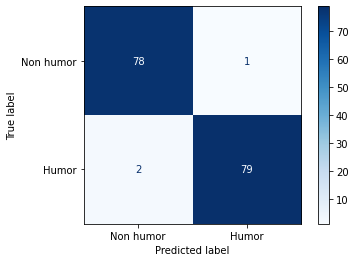

In [ ]:
#validate(colgpt2_model_loaded, X_test,  Y_test, batch_size, True)  #TODO run on full test dataset, but it takes hours to execute

_, _, _, _, _,cm, cr = validate(colbert_model_loaded, [x_test_comp[:160] for x_test_comp in X_test], Y_test[:160], batch_size)  #TODO run on full test dataset
print(cr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non humor', 'Humor'])
disp.plot(cmap='Blues')
plt.show()
